In [ ]:
# !pip install yfinance

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import yfinance as yf

In [ ]:
def calculate_log_return(df, column_name='Close'):
    # Calculate the log returns
    log_returns = np.log(df[column_name] / df[column_name].shift(1))
    return log_returns
def Get_hist(name,year):
    data = yf.Ticker(name)
    hist = data.history(period = year, interval='1d')
    df = pd.DataFrame(hist)
    df = df.dropna()
    df['Log_R'] = calculate_log_return(df)
    df = df.fillna(0)
    return df['Log_R'].reset_index()

In [ ]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NVDA', 'META', 'TSLA']
data = {}
for name in tech_list:
    data[name]=Get_hist(name,"3y")

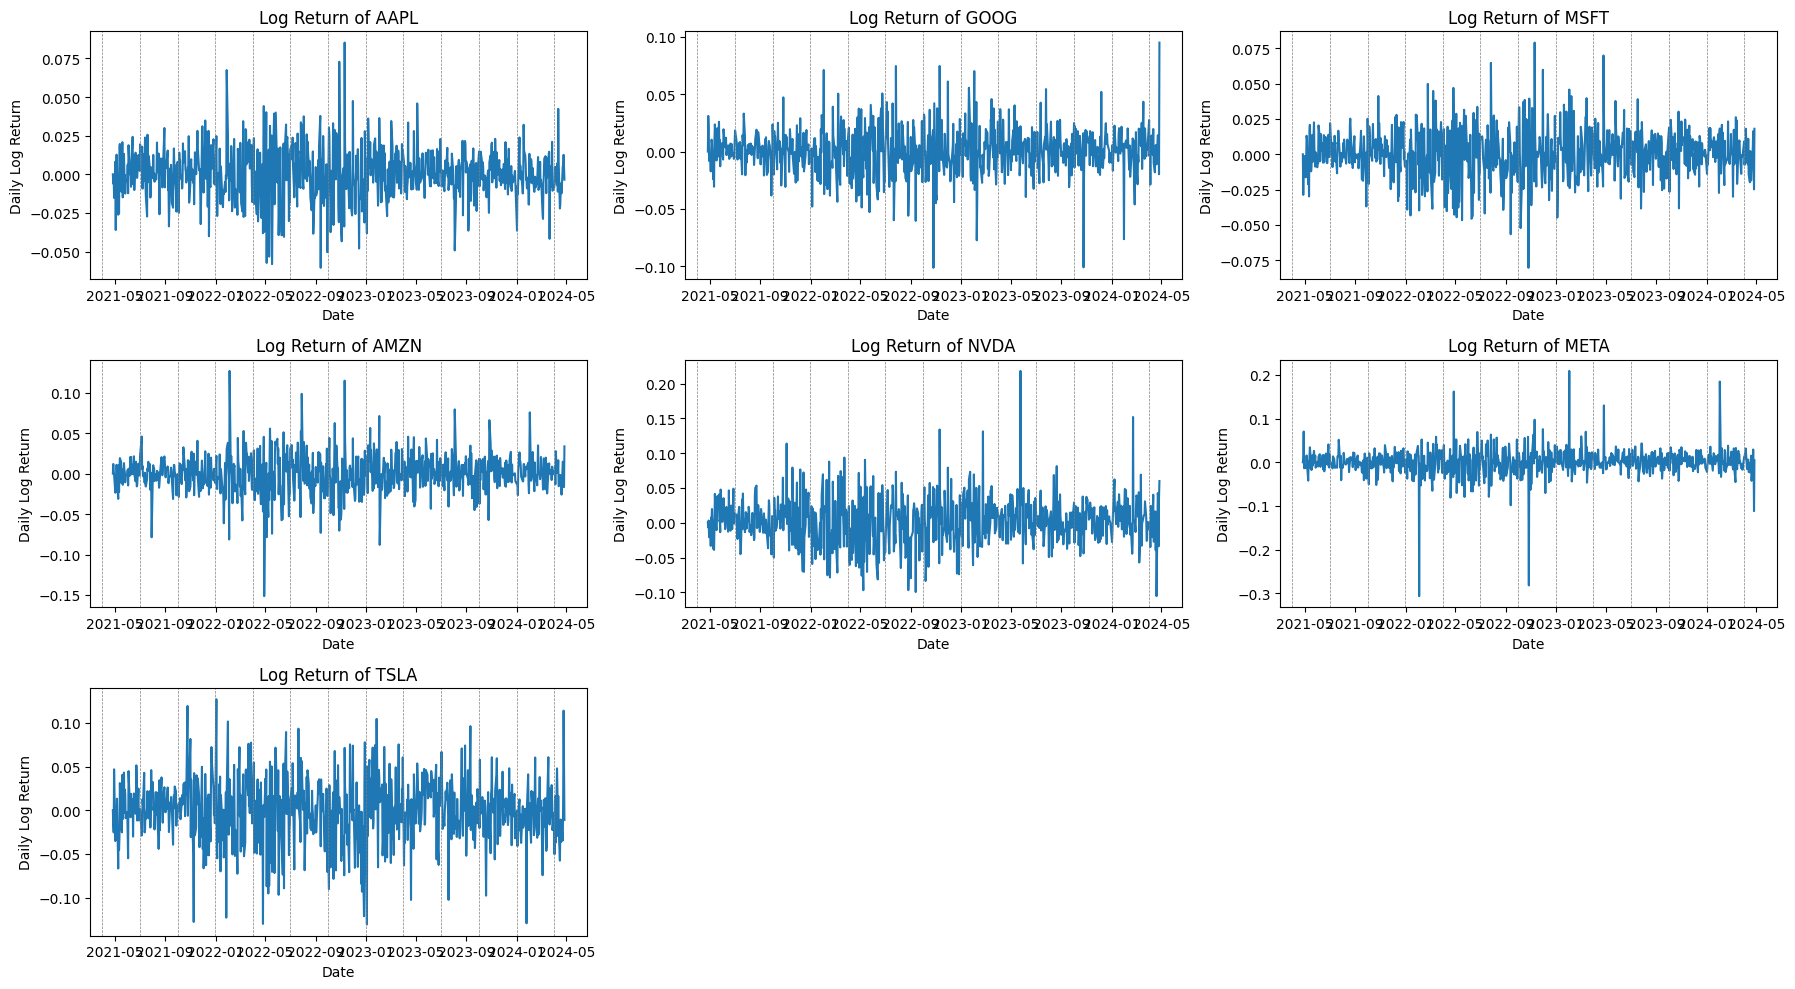

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(18, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(data.keys(), 1):
    plt.subplot(3, 3, i)
    sns.lineplot(data=data[company], x='Date', y='Log_R')
    plt.ylabel('Daily Log Return')
    plt.xlabel('Date')
    plt.title(f"Log Return of {company}")

    xlims = plt.xlim()

    for year in range(data[company]['Date'].dt.year.min(), data[company]['Date'].dt.year.max() + 1):
        for month in [1, 4, 7, 10]:
            plt.axvline(pd.to_datetime(f'{year}-{month}-01'), color='gray', linestyle='--', linewidth=0.5)

    plt.xlim(xlims)

plt.tight_layout()
plt.show()


"# Calculate average daily returns across the NASDAQ 100\nNASDAQ_returns['Average'] = NASDAQ_returns.mean(axis=1)\n\n# Plotting\nplt.figure(figsize=(12, 6))\nsns.lineplot(data=NASDAQ_returns, x=NASDAQ_returns.index, y='Average')\nplt.title('Average Daily Log Returns of NASDAQ 100 Stocks')\nplt.xlabel('Date')\nplt.ylabel('Average Daily Log Return')\nplt.grid(True)\nplt.show()"

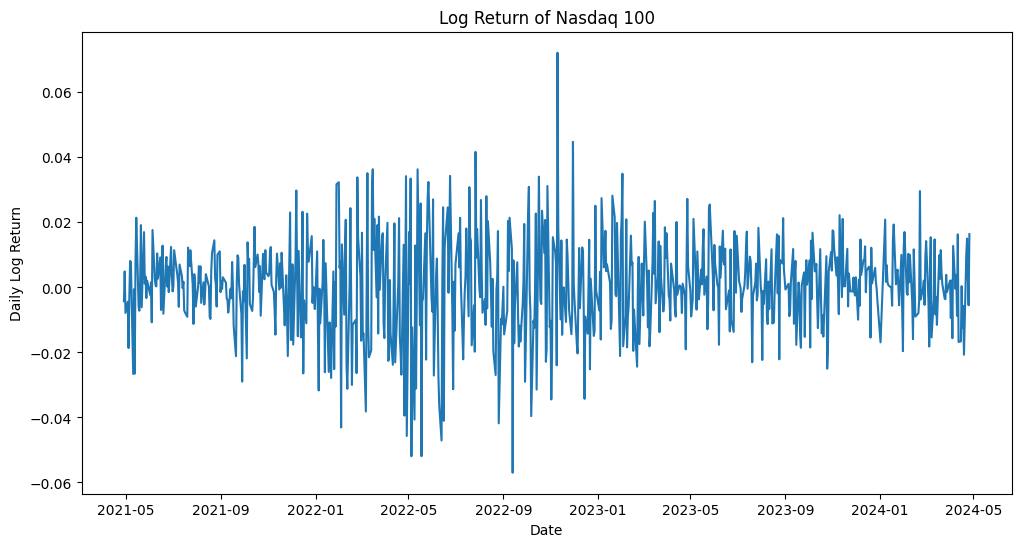

In [ ]:
def calculate_log_return(df, column_name='Close'):
    # Calculate the log returns
    log_returns = np.log(df[column_name] / df[column_name].shift(1))
    return log_returns

def get_stock_data(stock, period="3y"):
    """ Fetch historical stock data and calculate log returns """
    ticker = yf.Ticker(stock)
    hist = ticker.history(period=period, interval='1d')
    hist.dropna(inplace=True)
    hist['Log_R'] = calculate_log_return(hist)
    hist.reset_index(inplace=True)
    return hist[['Date', 'Log_R']]

'''
# Use the appropriate URL for the Wikipedia page
url = 'https://en.wikipedia.org/wiki/NASDAQ-100'

# Read in the tables from the Wikipedia page
tables = pd.read_html(url)

# The 4th table on the page (index 3) contains the NASDAQ 100 constituents
nasdaq_100_table = tables[3]

# Normalize the column names
nasdaq_100_table.columns = [col.strip() for col in nasdaq_100_table.columns]

# Extract the 'Ticker' column
try:
    tickers = nasdaq_100_table['Ticker']
except KeyError:
    # If there's still a KeyError, let's see what the column names actually are
    print("Column names found:", nasdaq_100_table.columns)
    raise
'''

# Get NASDAQ 100 stock symbols
nasdaq_100_stocks = ["^NDX"]

# Collect data for each stock
stock_data = {}
for stock in nasdaq_100_stocks:
    try:
        stock_data[stock] = get_stock_data(stock, period="3y")
    except Exception as e:
        print(f"Failed to fetch data for {stock}: {e}")

# Combine all stock data
NASDAQ_returns = pd.concat([df.set_index('Date')['Log_R'] for df in stock_data.values()], axis=1)
#NASDAQ_returns.columns = stock_data.keys()
plt.figure(figsize=(12, 6))
sns.lineplot(data=NASDAQ_returns, x=NASDAQ_returns.index, y='Log_R')
plt.xlabel('Date')
plt.ylabel('Daily Log Return')
plt.title(f"Log Return of Nasdaq 100")
'''# Calculate average daily returns across the NASDAQ 100
NASDAQ_returns['Average'] = NASDAQ_returns.mean(axis=1)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=NASDAQ_returns, x=NASDAQ_returns.index, y='Average')
plt.title('Average Daily Log Returns of NASDAQ 100 Stocks')
plt.xlabel('Date')
plt.ylabel('Average Daily Log Return')
plt.grid(True)
plt.show()'''


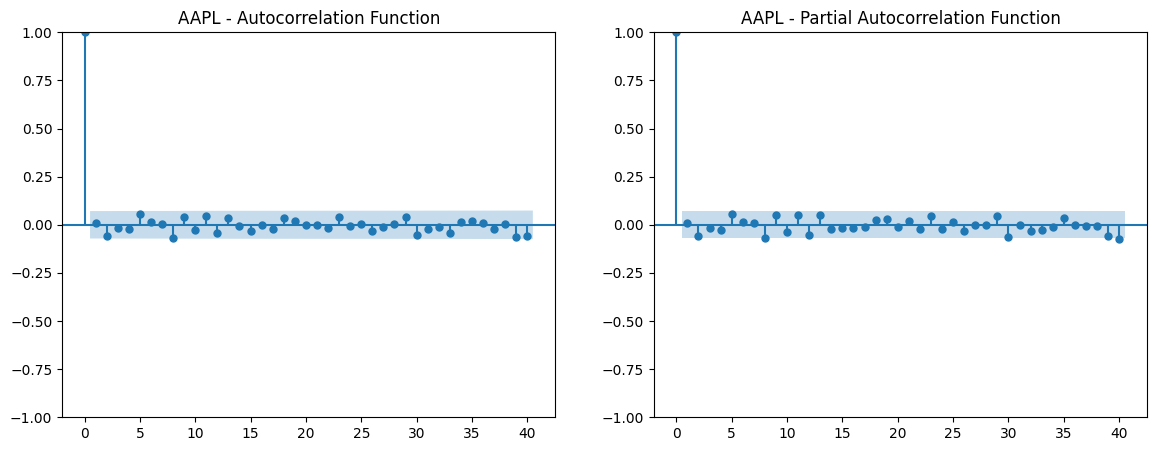

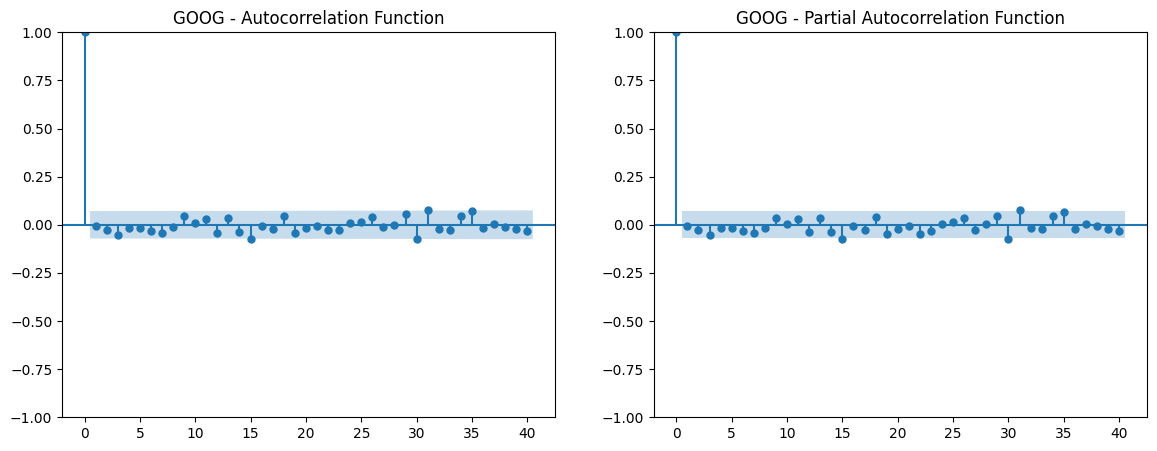

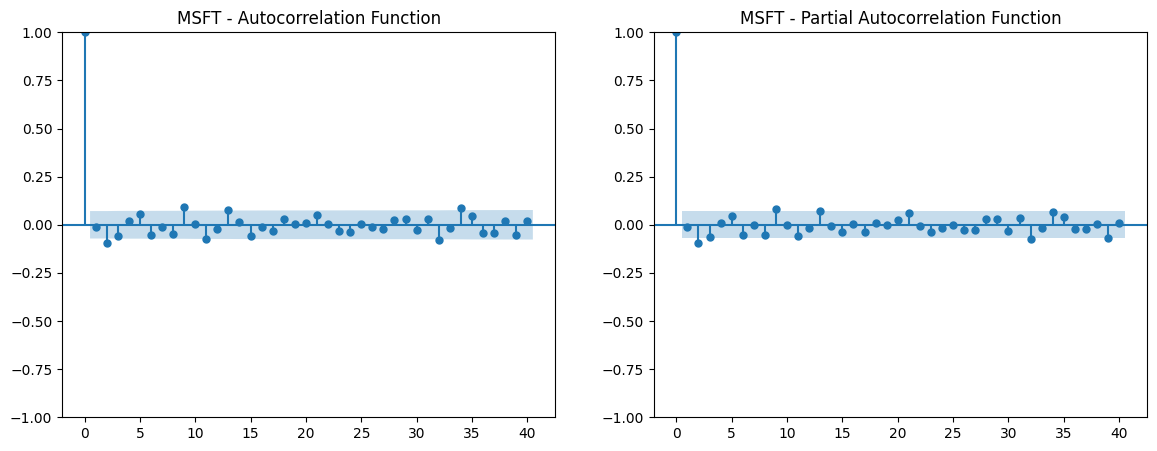

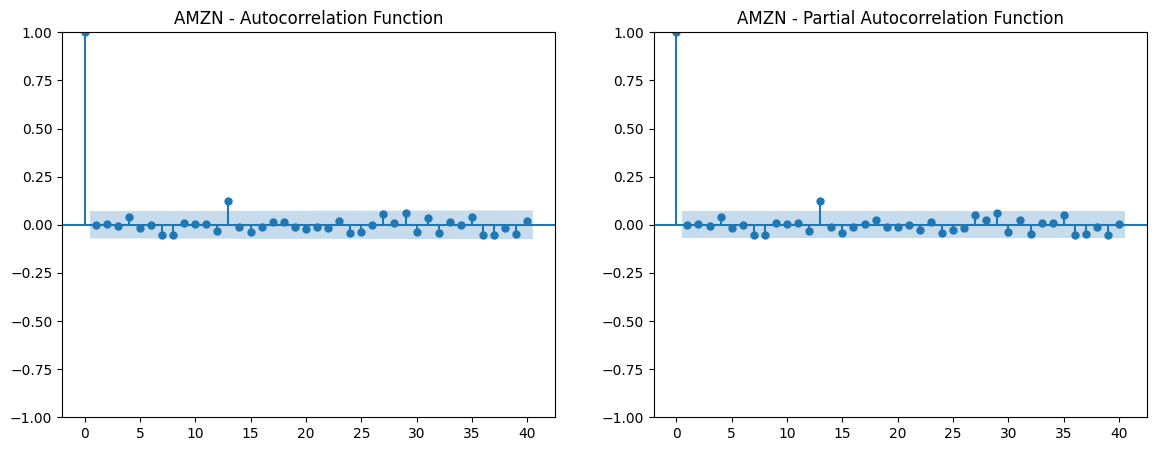

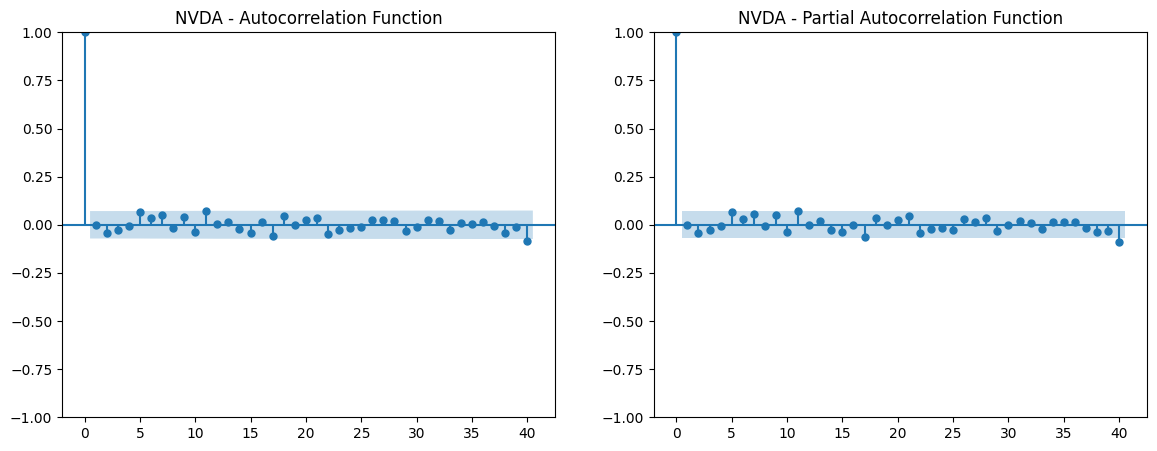

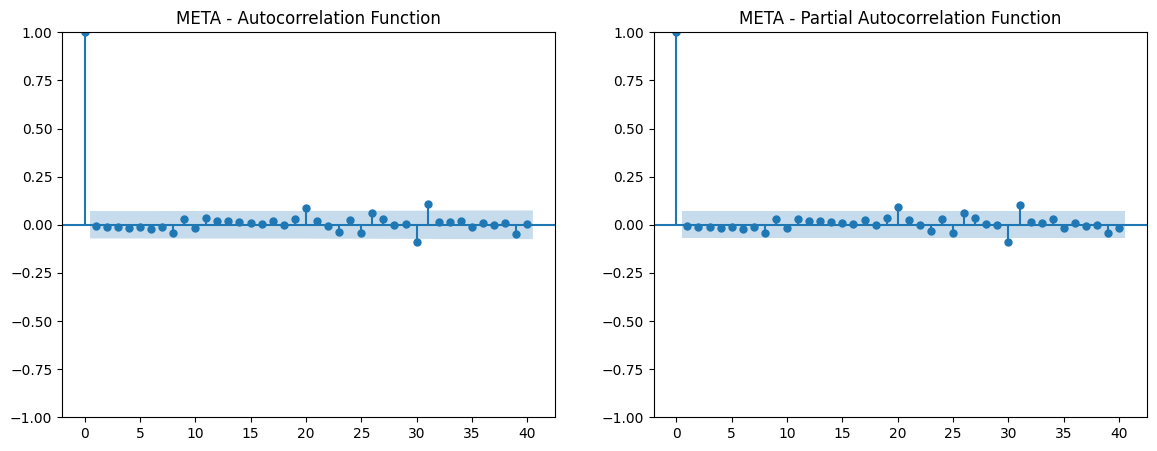

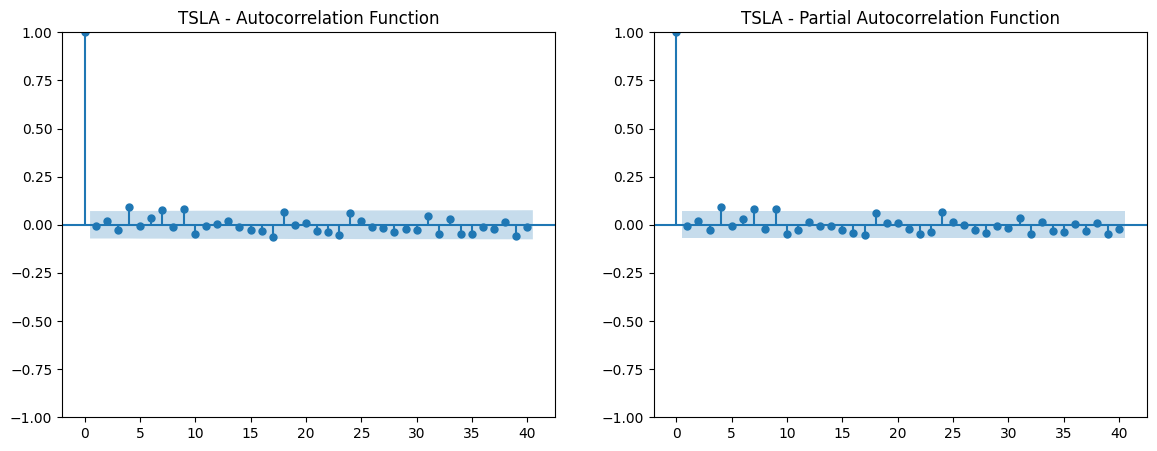

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


for company in tech_list:
    df = data[company]
    df.dropna(subset=['Log_R'], inplace=True)

    # Create figure for ACF and PACF plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ACF plot
    plot_acf(df['Log_R'], ax=axes[0], lags=40, title=f'{company} - Autocorrelation Function')

    # PACF plot
    plot_pacf(df['Log_R'], ax=axes[1], lags=40, title=f'{company} - Partial Autocorrelation Function')

    plt.show()


## Through the plots, there is no significant spike for each stocks. So p for would be 1.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
# Select the first company's data
def stationary_check(df):
# Check for stationarity
    adf_result = adfuller(df['Log_R'])
    if adf_result[1] > 0.05:
        print(f'ADF Statistic: {adf_result[0]}')
        print(f'p-value: {adf_result[1]}')
    else:
        print('It is stationary.')

In [ ]:
for name in tech_list:
    print(f'{name}:')
    stationary_check(df)

AAPL:
It is stationary.
GOOG:
It is stationary.
MSFT:
It is stationary.
AMZN:
It is stationary.
NVDA:
It is stationary.
META:
It is stationary.
TSLA:
It is stationary.


## VAR MODEL


In [ ]:
## First merge the data
def merge_data(data):
    merged_df = None
    for company, df in data.items():
        df = df.set_index('Date')  # Set 'Date' as the index
        df.rename(columns={'Log_R': company}, inplace=True)  # Rename 'Log_R' to the company name
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')  # Merge on 'Date', including all dates ('outer' join)
    return merged_df

merged_df = merge_data(data)
merged_df.head(5)

,AAPL,GOOG,MSFT,AMZN,NVDA,META,TSLA
Date,,,,,,,
2021-04-27 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-28 00:00:00-04:00,-0.006046,0.031063,-0.028694,0.011946,-0.006850,0.011561,-0.014781
2021-04-29 00:00:00-04:00,-0.000749,0.020783,-0.008086,0.003697,0.003137,0.070433,-0.025377
2021-04-30 00:00:00-04:00,-0.015249,-0.008169,-0.001308,-0.001121,-0.020786,-0.013535,0.046805
2021-05-03 00:00:00-04:00,0.008182,-0.006222,-0.001270,-0.023617,-0.011576,-0.007720,-0.035203


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2021-04-27 00:00:00-04:00 to 2024-04-26 00:00:00-04:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    756 non-null    float64
 1   GOOG    756 non-null    float64
 2   MSFT    756 non-null    float64
 3   AMZN    756 non-null    float64
 4   NVDA    756 non-null    float64
 5   META    756 non-null    float64
 6   TSLA    756 non-null    float64
dtypes: float64(7)
memory usage: 63.4 KB


In [ ]:
merged_df.corr()

,AAPL,GOOG,MSFT,AMZN,NVDA,META,TSLA
AAPL,1.000000,0.653652,0.707392,0.590811,0.594073,0.503444,0.515187
GOOG,0.653652,1.000000,0.711793,0.661256,0.585055,0.592382,0.390611
MSFT,0.707392,0.711793,1.000000,0.671245,0.665830,0.569814,0.422356
AMZN,0.590811,0.661256,0.671245,1.000000,0.593490,0.586336,0.429055
NVDA,0.594073,0.585055,0.665830,0.593490,1.000000,0.500525,0.493475
META,0.503444,0.592382,0.569814,0.586336,0.500525,1.000000,0.319794
TSLA,0.515187,0.390611,0.422356,0.429055,0.493475,0.319794,1.000000


These stocks are highly correlated.

# Checking model efficiency

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data = merged_df  # Your time series dataframe
data = data.reset_index(drop=False)

# Assuming 'df' is your DataFrame and 'date' is your column with date information
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Creating a complete business day index from the start to the end of your dataset
new_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='B')

# Reindex the DataFrame to include all business days, filling missing values if necessary
data = data.reindex(new_index, fill_value=0)  # You can change 'fill_value' based on how you want to handle missing data

train_size = int(len(data) * 0.9)
validation_size = 5  # One period for validation
total_periods = len(data)

def rolling_cv_metrics(data, lags):
    rmse_list = []
    r2_list = []
    for start in range(train_size, total_periods - validation_size):
        train_data = data.iloc[:start]
        valid_data = data.iloc[start:start + validation_size]

        model = VAR(train_data)
        results = model.fit(maxlags=lags)

        # Forecast
        forecast = results.forecast(train_data.values[-results.k_ar:], steps=validation_size)
        actual = valid_data.values

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        rmse_list.append(rmse)

        # Calculate R^2
        r2 = r2_score(actual, forecast)
        r2_list.append(r2)

    return rmse_list, r2_list

# Calculate RMSE and R^2 for different lags
max_lags_to_test = 30
mean_rmse = []
mean_r2 = []

for lags in range(1, max_lags_to_test + 1):
    rmses, r2s = rolling_cv_metrics(data, lags)
    mean_rmse.append(np.mean(rmses) if rmses else None)
    mean_r2.append(np.mean(r2s) if r2s else None)


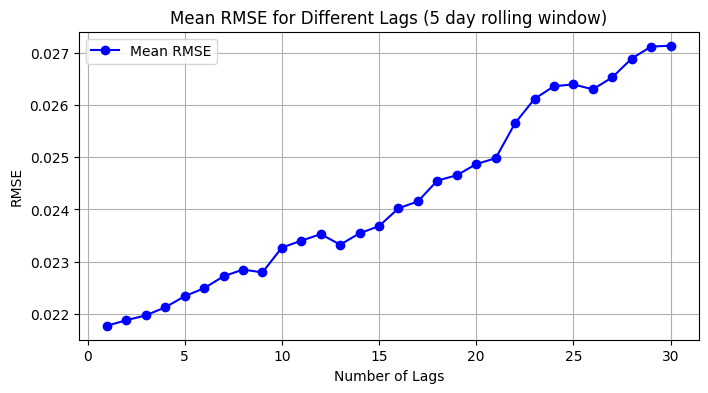

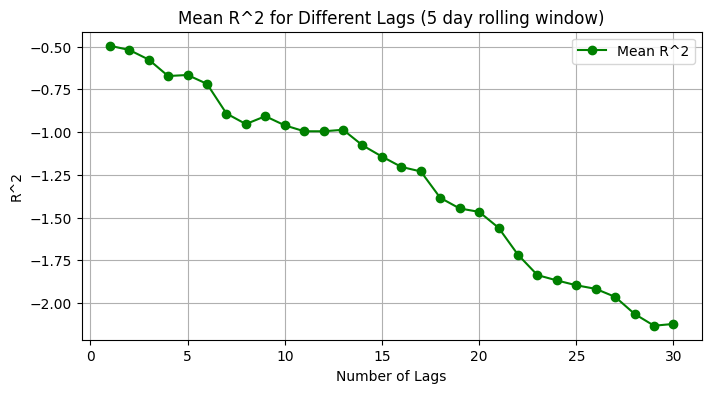

In [ ]:
# Plotting RMSE
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_lags_to_test + 1), mean_rmse, label='Mean RMSE', marker='o', linestyle='-', color='blue')
plt.title('Mean RMSE for Different Lags (5 day rolling window)')
plt.xlabel('Number of Lags')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Plotting R^2
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_lags_to_test + 1), mean_r2, label='Mean R^2', marker='o', linestyle='-', color='green')
plt.title('Mean R^2 for Different Lags (5 day rolling window)')
plt.xlabel('Number of Lags')
plt.ylabel('R^2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("The mean RMSE at lag 1 is: ", mean_rmse[0])
print("The mean R^2 at lag 1 is: ", mean_r2[0])

The mean RMSE at lag 1 is:  0.02177175935960642
The mean R^2 at lag 1 is:  -0.4948524094450579


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming 'NASDAQ_returns' is your DataFrame and has a 'Log_R' column with log returns
NASDAQ_train = NASDAQ_returns.iloc[:train_size]
NASDAQ_rolling_means = NASDAQ_train['Log_R'].rolling(window=validation_size).mean()
NASDAQ_rolling_variance = NASDAQ_train['Log_R'].rolling(window=validation_size).var()

train_size = int(len(data) * 0.9)
validation_size = 5  # One period for validation
total_periods = len(data)
risk_free_rate = 0.0516 / 252  # Daily risk-free rate, annualized to 5.16% - updated as of April 22

def sharpe_ratio(weights, means, cov, risk_free_rate):
    portfolio_return = np.dot(weights, means)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

def optimize_portfolio(returns):
    means = np.mean(returns, axis=0)
    cov = np.cov(returns, rowvar=False)
    num_assets = returns.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = np.array(num_assets * [1. / num_assets])
    result = minimize(sharpe_ratio, initial_guess, args=(means, cov, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Prepare lists to store the NASDAQ rolling averages
nasdaq_rolling_means = []
nasdaq_rolling_variances = []
actual_means = []
actual_variances = []
optimized_means = []
optimized_variances = []
all_weights = []
optimized_sharpe_ratios = []

for start in range(train_size, total_periods - validation_size):
    train_data = data.iloc[:start]
    valid_data = data.iloc[start:start + validation_size]

    # Compute the actual historical equally weighted returns and variance
    actual_return = valid_data.mean(axis=1)
    actual_variance = valid_data.var(axis=1)

    # Compute the rolling 5-day mean and variance for the actual data
    actual_rolling_mean = actual_return.rolling(window=validation_size).mean().iloc[-1]  # Take the last element which is the rolling mean of the current window
    actual_rolling_variance = actual_variance.rolling(window=validation_size).mean().iloc[-1]  # Take the last element which is the rolling variance of the current window

    actual_means.append(actual_rolling_mean)
    actual_variances.append(actual_rolling_variance)

    # Synchronize NASDAQ returns rolling window with the validation dates
    nasdaq_valid_data = NASDAQ_returns.iloc[start:start + validation_size]
    nasdaq_rolling_mean = NASDAQ_rolling_means[start - train_size:start - train_size + validation_size].mean()
    nasdaq_rolling_means.append(nasdaq_rolling_mean)
    nasdaq_rolling_variance = NASDAQ_rolling_variance[start - train_size:start - train_size + validation_size].var()
    nasdaq_rolling_variances.append(nasdaq_rolling_variance)

    model = VAR(train_data)
    results = model.fit(maxlags=1)

    # Forecast
    forecast = results.forecast(train_data.values[-results.k_ar:], steps=validation_size)
    actual = valid_data.values

    # Optimize portfolio for the forecast
    optimized_weights = optimize_portfolio(forecast)
    all_weights.append(optimized_weights)
    forecast_mean = np.mean(forecast, axis=0)
    forecast_cov = np.cov(forecast, rowvar=False)

    # Calculate optimized return and volatility
    optimized_return = np.dot(optimized_weights, forecast_mean)
    optimized_volatility = np.dot(optimized_weights.T, np.dot(forecast_cov, optimized_weights))

    # Append optimized returns and volatilities to their respective lists
    optimized_means.append(optimized_return)
    optimized_variances.append(optimized_volatility)

    # Calculate Sharpe ratio for the optimized portfolio
    current_sharpe_ratio = -sharpe_ratio(optimized_weights, forecast_mean, forecast_cov, risk_free_rate)
    optimized_sharpe_ratios.append(current_sharpe_ratio)

# Convert list of weights to a DataFrame for easier manipulation
weights_df = pd.DataFrame(all_weights, columns=[f'Stock {i+1}' for i in range(7)])

# Define the new column names as a list
new_column_names = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NVDA', 'META', 'TSLA']

# Rename the columns of weights_df
weights_df.columns = new_column_names

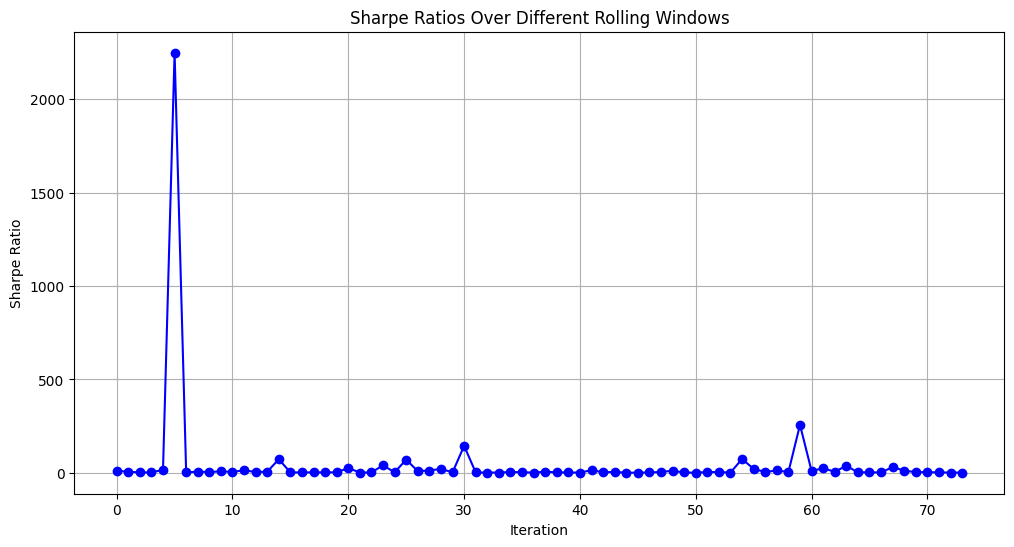

In [ ]:
# Plotting the Sharpe ratios for all rolling window periods
plt.figure(figsize=(12, 6))
plt.plot(optimized_sharpe_ratios, marker='o', linestyle='-', color='blue')
plt.title('Sharpe Ratios Over Different Rolling Windows')
plt.xlabel('Iteration')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

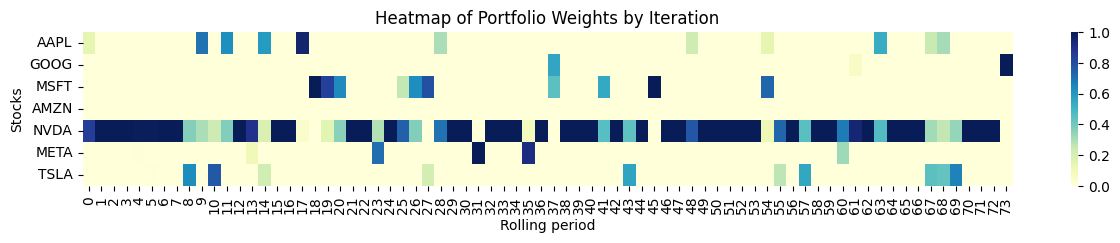

In [ ]:
import seaborn as sns

# Assuming 'weights_df' is a DataFrame with columns as stock names and rows as iterations
plt.figure(figsize=(15, 2))
sns.heatmap(weights_df.T, cmap='YlGnBu', cbar=True, xticklabels=True, yticklabels=True)
plt.title('Heatmap of Portfolio Weights by Iteration')
plt.xlabel('Rolling period')
plt.ylabel('Stocks')
plt.show()

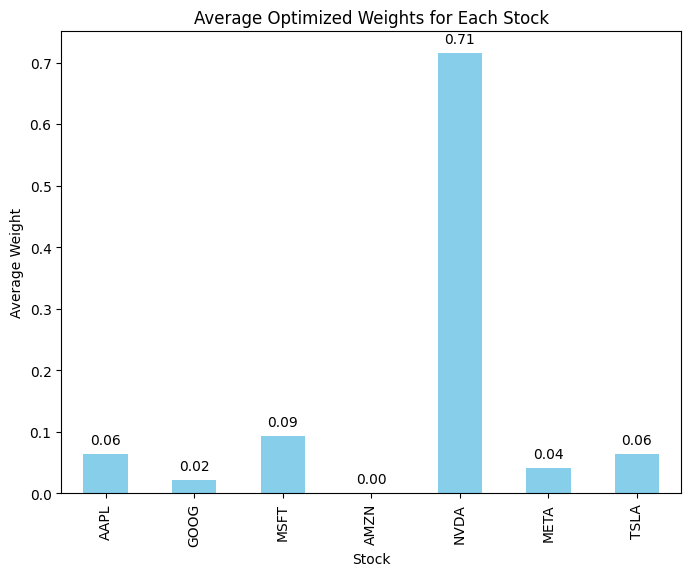

In [ ]:
# Calculating the average weights
average_weights = weights_df.mean()

# Plotting the bar chart
ax = average_weights.plot(kind='bar', color='skyblue', figsize=(8, 6))

# Adding a title and labels
plt.title('Average Optimized Weights for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Average Weight')

# Annotating the height of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


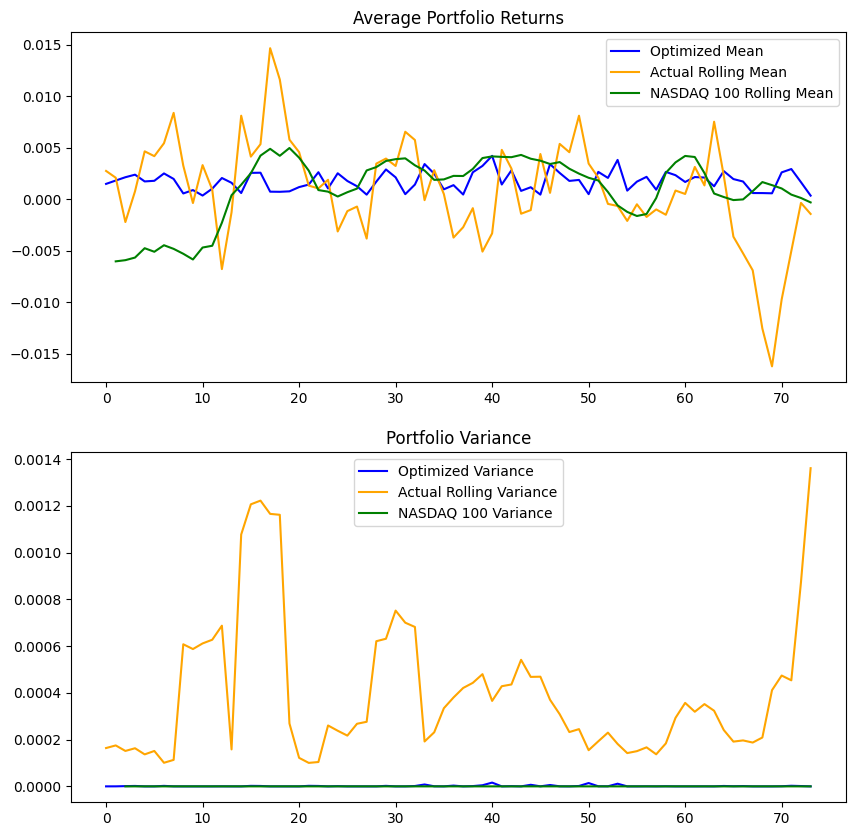

In [ ]:
# Plotting section includes the actual values
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# First plot for average returns
axs[0].plot(optimized_means, color='blue', label='Optimized Mean')
axs[0].plot(actual_means, color='orange', label='Actual Rolling Mean')
axs[0].plot(nasdaq_rolling_means, color='green', label='NASDAQ 100 Rolling Mean')
axs[0].set_title('Average Portfolio Returns')
axs[0].legend()

# Second plot for variances
axs[1].plot(optimized_variances, color='blue', label='Optimized Variance')
axs[1].plot(actual_variances, color='orange', label='Actual Rolling Variance')
axs[1].plot(nasdaq_rolling_variances, color='green', label='NASDAQ 100 Variance')
axs[1].set_title('Portfolio Variance')
axs[1].legend()

plt.show()

In [ ]:
nasdaq_rolling_means = [0 if np.isnan(x) else x for x in nasdaq_rolling_means]

In [ ]:
import math

# Ensure these lists are numpy arrays to easily calculate means
optimized_means_np = np.array(optimized_means)
equal_weight_means_np = np.array(actual_means)
nasdaq_means_np = np.array(nasdaq_rolling_means)
# nasdaq_rolling_means_np = np.array(nasdaq_rolling_means)
optimized_variances_np = np.array(optimized_variances)
equal_weight_variances_np = np.array(actual_variances)
nasdaq_variances = np.array(nasdaq_rolling_variances)
nasdaq_variances = np.nan_to_num(nasdaq_variances)

# nasdaq_rolling_variance would need to be calculated similar to nasdaq_rolling_means

# Compute the average of each list/array
average_optimized_mean = np.mean(optimized_means_np) * 252
average_equal_weight_mean = np.mean(equal_weight_means_np) * 252
average_nasdaq_means_np = np.mean(nasdaq_means_np) * 252
# average_nasdaq_rolling_mean = np.mean(nasdaq_rolling_means_np) * 252/5
average_optimized_variance = np.mean(optimized_variances_np) * math.sqrt(252)
average_equal_weight_variance = np.mean(equal_weight_variances_np) * math.sqrt(252)
average_nasdaq_variance = np.mean(nasdaq_variances) * math.sqrt(252)
vol_optimized = np.sqrt(average_optimized_variance)
vol_eq_weight = np.sqrt(average_equal_weight_variance)
vol_nasdaq = np.sqrt(average_nasdaq_variance)
# average_nasdaq_rolling_variance = np.mean(nasdaq_rolling_variance_np) * math.sqrt(252/5)
print(f"Average Optimized Portfolio Mean: {average_optimized_mean * 100:.2f}%")
print(f"Average Equal Weight Portfolio Mean: {average_equal_weight_mean * 100:.2f}%")
print(f"Average NASDAQ 100 Rolling Mean: {average_nasdaq_means_np * 100:.2f}%")
print(f"Average Optimized Portfolio Variance: {average_optimized_variance * 100:.6f}%")
print(f"Average Equal Weight Portfolio Variance: {average_equal_weight_variance * 100:.6f}%")
print(f"Average NASDAQ 100 Rolling Variance: {average_nasdaq_variance * 100:.6f}%")
print(f"Average Optimized Portfolio Vol: {vol_optimized * 100:.6f}%")
print(f"Average Equal Weight Portfolio Vol: {vol_eq_weight * 100:.6f}%")
print(f"Average NASDAQ 100 Rolling Vol: {vol_nasdaq * 100:.6f}%")

Average Optimized Portfolio Mean: 43.52%
Average Equal Weight Portfolio Mean: 22.07%
Average NASDAQ 100 Rolling Mean: 24.16%
Average Optimized Portfolio Variance: 0.002217%
Average Equal Weight Portfolio Variance: 0.635674%
Average NASDAQ 100 Rolling Variance: 0.000003%
Average Optimized Portfolio Vol: 0.470886%
Average Equal Weight Portfolio Vol: 7.972918%
Average NASDAQ 100 Rolling Vol: 0.016580%


In [ ]:
from statsmodels.stats.stattools import durbin_watson

# Assuming 'results' is the output of your VAR model fitting
residuals = results.resid

# Durbin-Watson Test
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic (close to 2.0 indicates no autocorrelation): {dw_stat}')


Durbin-Watson statistic (close to 2.0 indicates no autocorrelation): [1.99455052 1.99141105 1.99351765 1.99205892 1.99792265 1.99939487
 1.99748746]


In [ ]:
nasdaq_rolling_mean

-0.0003210095891404812

# Portfolio Statistics

### Daily Returns

### Cumulative Returns

In [ ]:
def calculate_cumulative_returns(portfolio_returns):
    cumulative_returns = portfolio_returns.cumsum()
    cumulative_returns.iloc[0] = 0
    cumulative_returns.name = 'Cumulative Returns'
    return cumulative_returns

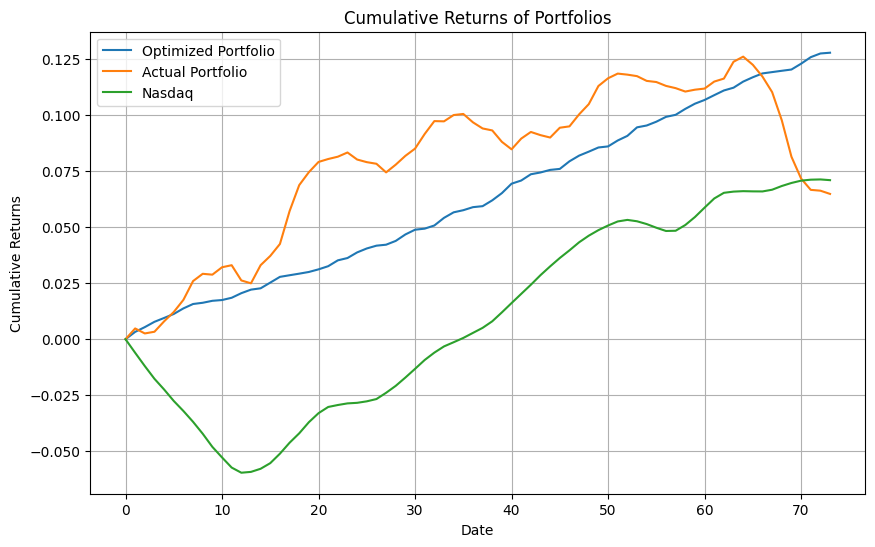

In [ ]:
cumulative_returns1 = calculate_cumulative_returns(pd.Series(optimized_means))
cumulative_returns2 = calculate_cumulative_returns(pd.Series(actual_means))
cumulative_returns3 = calculate_cumulative_returns(pd.Series(nasdaq_rolling_means))
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns1, label='Optimized Portfolio')
plt.plot(cumulative_returns2, label='Actual Portfolio')
plt.plot(cumulative_returns3, label='Nasdaq')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Portfolios')
plt.legend()
plt.grid(True)
plt.show()

### Sharpe Ratio & Sortino Ratio

In [ ]:
def calculate_sharpe_ratio(portfolio_return, annualized_volatility, risk_free_rate):
    """
    Calculate the Sharpe ratio of a portfolio.

    Args:
    portfolio_return (float): Annualized return of the portfolio.
    annualized_volatility (float): Annualized volatility of the portfolio.
    risk_free_rate (float): Risk-free rate of return.

    Returns:
    float: Sharpe ratio of the portfolio.
    """
    sharpe_ratio = (portfolio_return - risk_free_rate) / annualized_volatility
    return sharpe_ratio

def calculate_sortino_ratio(portfolio_return, downside_deviation, risk_free_rate, target_return):
    """
    Calculate the Sortino ratio of a portfolio.

    Args:
    portfolio_return (float):
    downside_deviation (float): Downside deviation of the portfolio.
    risk_free_rate (float): Risk-free rate of return.

    Returns:
    float: Sortino ratio of the portfolio.
    """
    negative_returns = np.minimum(portfolio_return - target_return, 0)

    # Calculate the downside deviation
    downside_deviation = np.sqrt(np.mean(negative_returns**2))

    sortino_ratio = (portfolio_return - risk_free_rate) / downside_deviation
    return sortino_ratio



In [ ]:
sharpe_optimized = calculate_sharpe_ratio((average_optimized_mean/252), np.sqrt(average_optimized_variance),(risk_free_rate) )
sharpe_equal = calculate_sharpe_ratio((average_equal_weight_mean/252), np.sqrt(average_equal_weight_variance),(risk_free_rate) )
sharpe_nasdaq = calculate_sharpe_ratio((average_nasdaq_means_np/252), np.sqrt(average_nasdaq_variance), (risk_free_rate))
sortino_optimized = calculate_sortino_ratio((average_optimized_mean/252), np.sqrt(average_optimized_variance),(risk_free_rate), 0.025)
sortino_equal = calculate_sortino_ratio((average_equal_weight_mean/252), np.sqrt(average_equal_weight_variance),(risk_free_rate), 0.025)
sortino_nasdaq = calculate_sortino_ratio((average_nasdaq_means_np/252), np.sqrt(average_nasdaq_variance), (risk_free_rate), 0.025)

In [ ]:
sharpe_optimized, sharpe_equal, sharpe_nasdaq , sortino_optimized, sortino_equal, sortino_nasdaq

(0.3232392212394266,
 0.0084170924931243,
 4.547701726778029,
 0.06540101384429949,
 0.027818095063594762,
 0.031363408350838964)

In [ ]:
def drawdown(portfolio_return):
  previous_peaks = portfolio_return.cummax()

    # Calculate drawdown as the difference between cumulative returns and previous peaks
  drawdown = (portfolio_return - previous_peaks) / previous_peaks

  return drawdown

In [ ]:
import pandas as pd

def calculate_drawdown(daily_returns):
    # Convert daily returns to cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()

    # Calculate the previous peaks
    previous_peaks = cumulative_returns.cummax()

    # Calculate drawdown as the difference between cumulative returns and previous peaks
    drawdown = (cumulative_returns - previous_peaks) / previous_peaks

    return drawdown


portfolio_drawdown = calculate_drawdown(pd.Series(optimized_means))
portfolio_drawdown1 = calculate_drawdown(pd.Series(actual_means))
portfolio_drawdown2 = calculate_drawdown(pd.Series(nasdaq_rolling_means))


# Calculate the maximum drawdown
max_drawdown = portfolio_drawdown.min()
max_drawdown1 = portfolio_drawdown1.min()
max_drawdown2 = portfolio_drawdown2.min()

print("Maximum Drawdown:", max_drawdown)
print("Maximum Drawdown:", max_drawdown1)
print("Maximum Drawdown:", max_drawdown2)


Maximum Drawdown: 0.0
Maximum Drawdown: -0.0596908453138915
Maximum Drawdown: -0.057945170784604705


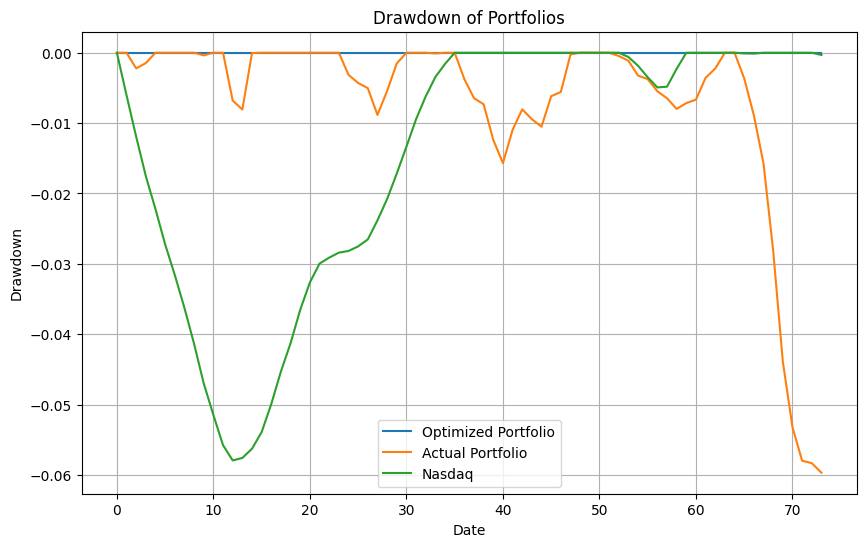

In [ ]:
drawdown_optimized = calculate_drawdown(pd.Series(optimized_means))
drawdown_equal = calculate_drawdown(pd.Series(actual_means))
drawdown_nasdaq = calculate_drawdown(pd.Series(nasdaq_rolling_means))
plt.figure(figsize=(10, 6))
plt.plot(drawdown_optimized, label='Optimized Portfolio')
plt.plot(drawdown_equal, label='Actual Portfolio')
plt.plot(drawdown_nasdaq, label='Nasdaq')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdown of Portfolios')
plt.legend()
plt.grid(True)
plt.show()

### Value-at-Risk & Expected Shortfall

In [ ]:
def calculate_value_at_risk(portfolio_returns, alpha):
    """
    Calculate the Value at Risk (VaR) of a portfolio.

    Args:
    portfolio_returns (array or pandas DataFrame): Array or DataFrame containing portfolio returns.
    alpha (float): Significance level (e.g., 0.05 for 95% confidence level).

    Returns:
    float: Value at Risk (VaR) of the portfolio.
    """
    var = -np.percentile(portfolio_returns, 100 - alpha * 100)
    return var

def calculate_expected_shortfall(portfolio_returns, alpha):
    """
    Calculate the Expected Shortfall (ES) of a portfolio.

    Args:
    portfolio_returns (array or pandas DataFrame): Array or DataFrame containing portfolio returns.
    alpha (float): Significance level (e.g., 0.05 for 95% confidence level).

    Returns:
    float: Expected Shortfall (ES) of the portfolio.
    """
    var = calculate_value_at_risk(portfolio_returns, alpha)
    es = -np.mean(portfolio_returns[portfolio_returns < -var])
    return es



In [ ]:
###Number of Positive and Negative Days
def count_positive_negative_days(daily_returns):

    # Count the number of positive and negative days
    positive_days = (daily_returns > 0).sum()
    negative_days = (daily_returns < 0).sum()

    return positive_days, negative_days

positive_days_opt, negative_days_opt= count_positive_negative_days(pd.Series(optimized_means))
positive_days_eq, negative_days_eq = count_positive_negative_days(pd.Series(actual_means))
positive_days_ndx, negative_days_ndx = count_positive_negative_days(pd.Series(nasdaq_rolling_means))
print("Number of positive days:", positive_days_opt)
print("Number of positive days:", positive_days_eq)
print("Number of positive days:", positive_days_ndx)

print("Number of negative days:", negative_days_opt)
print("Number of negative days:", negative_days_eq)
print("Number of negative days:", negative_days_ndx)


Number of positive days: 74
Number of positive days: 42
Number of positive days: 54
Number of negative days: 0
Number of negative days: 32
Number of negative days: 19


### Beta to Nasdaq 100

In [ ]:
def calculate_beta(portfolio_returns, benchmark_returns):
    # Calculate covariance and variance
    covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
    variance = np.var(benchmark_returns)

    # Calculate beta
    beta = covariance / variance

    return beta

beta_opt = calculate_beta(cumulative_returns1, cumulative_returns3)
beta_eq = calculate_beta(cumulative_returns2, cumulative_returns3)
print("Beta:", beta_opt)
print("Beta:", beta_eq)


Beta: 0.8357547290326666
Beta: 0.5720345156142305
